In [137]:
import ollama
from pathlib import Path
from PIL import Image
import os
%matplotlib inline

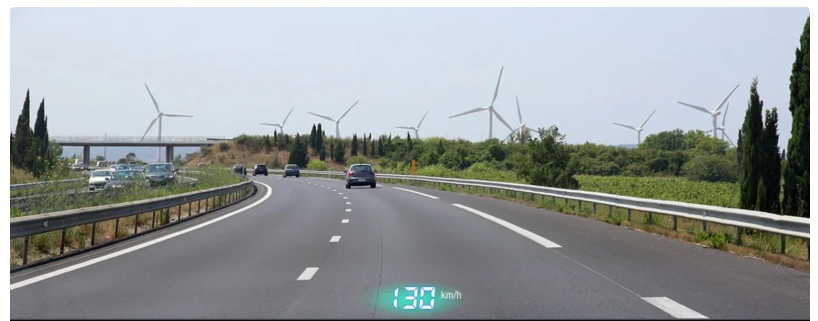

In [15]:
img_folder = Path('./img')
img_path = img_folder / 'drive.png'

image = Image.open(img_path).convert('RGB')
image

In [16]:
response = ollama.chat(
    model='llava:7b',
    messages=[{
        'role': 'user',
        'content': 'At what coordinates the speed text is located?',
        'images': [img_path]
    }]
)

print(response['message'])

role='assistant' content=' The image shows a highway scene with a timestamp "1:34" and the location is indicated as "Catalonia, Spain." There\'s also a timestamp that says "1:34", which could be related to the time when the photo was taken or edited. The image includes a speed limit sign, but the coordinates of where the speed text is located within the image are not clearly visible due to the angle and composition of the photograph. If you need help with determining the location of objects within an image, please provide a more detailed view or context. ' images=None tool_calls=None


In [1]:
import torch
import torch.nn as nn
from transformers import CLIPVisionModel


model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14")

/home/thodemon/miniconda3/envs/llava/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from transformers import CLIPImageProcessor

vision_encoder_path = "openai/clip-vit-large-patch14"

image_processor = CLIPImageProcessor.from_pretrained(vision_encoder_path, use_fast=False)

# Processing

In [76]:
import dataclasses
from typing import List


@dataclasses.dataclass
class Conversation:
    """A class that keeps all conversation history."""
    system: str
    roles: List[str]
    sep_style: str
    sep: str = "###"
    sep2: str = None

    def get_prompt(self, messages):
        if self.sep_style == 'single':
            ret = self.system + self.sep
            for role, message in messages:
                if message:
                    if type(message) is tuple:
                        message, _, _ = message
                    ret += role + ": " + message + self.sep
                else:
                    ret += role + ":"

        elif self.sep_style == 'two':
            seps = [self.sep, self.sep2]
            ret = self.system + self.sep
            for i, (role, message) in enumerate(messages):
                if message:
                    if type(message) is tuple:
                        message, _, _ = message
                    ret += role + ": " + message + seps[i % 2]
                else:
                    ret += role + ":"

        elif self.sep_style == 'plain':
            seps = [self.sep, self.sep2]
            ret = self.system
            for i, message in enumerate(messages):
                ret += message + seps[i % 2]

        elif self.sep_style == 'llama2':
            wrap_sys = lambda msg: f"<<SYS>>\n{msg}\n<</SYS>>\n\n"
            wrap_inst = lambda msg: f"[INST] {msg} [/INST]"
            ret = ""

            for i, (role, message) in enumerate(messages):
                if i == 0:
                    assert message, "first message should not be none"
                    assert role == self.roles[0], "first message should come from user"
                if message:
                    if type(message) is tuple:
                        message, _, _ = message
                    if i == 0: message = wrap_sys(self.system) + message
                    if i % 2 == 0:
                        message = wrap_inst(message)
                        ret += self.sep + message
                    else:
                        ret += " " + message + " " + self.sep2
                else:
                    ret += ""
            ret = ret.lstrip(self.sep)

        else:
            raise ValueError(f"Invalid style: {self.sep_style}")
        return ret
 
conv_llava = Conversation(
    system="System",
    roles=("USER", "ASSISTANT"),
    sep_style='two',
    sep=" ",
    sep2="</s>",
)

conv_templates = {
    "llava": conv_llava,
}

In [79]:
from torch.utils.data import Dataset
import json
import pathlib
from transformers import LlavaProcessor


IGNORE_INDEX = -100
DEFAULT_TOKENS = {
    'pad': "[PAD]",
    'bos': "<s>",
    'eos': "</s>",
    'unk': "<unk>",
    'sep': "<sep>",
    'boi': "<img>",
    'eoi': "</img>",
    'bor': "<roi>",
    'eor': "</roi>",
    'boe': "<p>",
    'eoe': "</p>",
    'image': "<image>",
    'region': "<region>",
    'rbox': "<refer_box>",
    'gbox': "<ground_box>",
    'rfeat': "<refer_feat>",
    'ground': "[grounding]",
}

class LLaVAInstruct(Dataset):
    """
    A dataset for the LLaVA Instruct dataset. It returns a dict with the following keys:
    - "id": The id of the conversation.
    - "image": The image file name.
    - "conversation": A list of dicts with the following keys:
        - "role": The role of the speaker (always "human" for this dataset)
        - "content": The content of the message.
    """
    def __init__(self, 
                 data_path: str,
                 image_dir: str,
                 ) -> None:
    
        self.data = json.load(open(data_path, "r"))
        self.image_dir = pathlib.Path(image_dir)
        self.conv_temp = conv_templates["llava"]

        self.processor = LlavaProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf", device='cuda')
        
        self.img_processor = self.processor.image_processor
        self.tokenizer = self.processor.tokenizer
        num_new_token = self.tokenizer.add_tokens(list(DEFAULT_TOKENS.values()), special_tokens=True)
        self.tokenizer.pad_token = DEFAULT_TOKENS['pad']

        self.seperator_id = self.tokenizer.convert_tokens_to_ids([DEFAULT_TOKENS['sep']])[0]
        self.eos_id = self.tokenizer.convert_tokens_to_ids([DEFAULT_TOKENS['eos']])[0]


        print(f"Loaded {len(self.data)} conversation samples from {data_path}")
        print(f"Image directory: {self.image_dir}")
        
    def __len__(self):
        return len(self.data)
    
    def _preprocess(self, conversations):

        new_conversations = []
        instruct = "instruction "
        instruct += "Image: {}. ".format(DEFAULT_TOKENS['image'])
        answer = 'answer'
        new_conversations.append((self.conv_temp.roles[0], instruct))
        new_conversations.append((self.conv_temp.roles[1], answer))
        
        assert len(conversations) % 2 == 0
        for i, conversation in enumerate(conversations):
            chat = conversation['value']
            chat = chat.replace('<image>', '')
            chat = chat.replace('\n', ' ')
            if i % 2 == 1:
                chat = DEFAULT_TOKENS['sep'] + chat + DEFAULT_TOKENS['sep']
            new_conversations.append((self.conv_temp.roles[i%2], chat))
        prompt = self.conv_temp.get_prompt(new_conversations)

        print(prompt)
        
        # tokenize conversations
        input_ids = self.tokenizer(
            prompt,
            return_tensors="pt",
            padding="longest",
            max_length=512,
            truncation=True
        ).input_ids[0]

        print(input_ids)

        # Mask targets
        targets = input_ids.clone()
        print(input_ids == self.seperator_id)
        sep_inds = (input_ids == self.seperator_id).nonzero(as_tuple=True)[0]

        assert len(sep_inds) % 2 == 0
        for i in range(0, len(sep_inds), 2):
            pre_sep = 0 if i == 0 else sep_inds[i - 1]
            cur_sep = sep_inds[i]
            targets[pre_sep:cur_sep] = IGNORE_INDEX
        eos_inds = (input_ids == self.eos_id).nonzero(as_tuple=True)[0]
        targets[eos_inds[1:]] = self.eos_id

        
        # Remove sep token
        mask = input_ids != self.seperator_id
        input_ids = input_ids[mask]
        targets = targets[mask]

        print(mask)


        data_dict = dict(
            input_ids=input_ids,
            labels=targets,
            source='llava'
        )
        return data_dict
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        return self._preprocess(sample["conversations"])
    

dataset = LLaVAInstruct(data_path="./datasets/complex_reasoning_77k.json", image_dir="/home/thodemon/workspace/datasets/coco/train2017")
dataset[0]

print('a')

Loaded 76643 conversation samples from ./datasets/complex_reasoning_77k.json
Image directory: /home/thodemon/workspace/datasets/coco/train2017
System USER: instruction Image: <image>.  ASSISTANT: answer</s>USER:  What skill set might someone need to perform such a frisbee trick? ASSISTANT: <sep>To perform the frisbee trick shown in the image, where the man is passing a frisbee between or underneath his legs, a person would need a combination of skills. These skills include good hand-eye coordination, agility, balance, flexibility, and dexterity. Additionally, the ability to throw and catch the frisbee accurately while maintaining control of bodily movements would also be essential. To perfect the trick, practicing these skills and building up muscle memory through repetition would be beneficial.<sep></s>
tensor([    1,  2184,  3148,  1001, 29901, 15278,  7084, 29901, 29871, 32000,
          869, 29871,   319,  1799,  9047, 13566, 29901,  1234,     2,  3148,
         1001, 29901, 29871,

In [80]:
dataset.processor.tokenizer

LlamaTokenizerFast(name_or_path='llava-hf/llava-1.5-7b-hf', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '[PAD]', 'image_token': '<image>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32000: AddedToken("<image>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32001: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32002: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, speci

In [61]:
dataset.processor.tokenizer.convert_tokens_to_ids([DEFAULT_TOKENS['image']])

[32000]

In [81]:
from transformers import AutoProcessor

llava_processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf", use_fast=True, device='cuda')

conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image", "url": "https://www.ilankelman.org/stopsigns/australia.jpg"},
                {"type": "text", "text": "What is shown in this image?"},
            ],
        },
    ]

inputs = llava_processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
)

In [82]:
llava_processor.tokenizer.decode(inputs['input_ids'][0])

'USER: <image> \nWhat is shown in this image? ASSISTANT:'

In [83]:
llava_processor

LlavaProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "LlavaProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 336
  }
}

- tokenizer: LlamaTokenizerFast(name_or_path='llava-hf/llava-1.5-7b-hf', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'image_token': '<image>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, 

# LLaVA Instruct Dataset

In [144]:
class LLaVAInstruct(Dataset):
    def __init__(self, 
                 data_path: str,
                 image_dir: str,
                 ) -> None:
    
        self.data = json.load(open(data_path, "r"))
        self.image_dir = os.path.abspath(image_dir) 

        print(f"Loaded {len(self.data)} conversation samples from {data_path}")
        print(f"Image directory: {self.image_dir}")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        image_path = os.path.join(self.image_dir, sample['image']) 
        sample['image'] = image_path
        return sample
    

dataset = LLaVAInstruct(data_path="./datasets/complex_reasoning_77k.json", image_dir="/home/thodemon/workspace/datasets/coco/train2017")
dataset[0]

Loaded 76643 conversation samples from ./datasets/complex_reasoning_77k.json
Image directory: /home/thodemon/workspace/datasets/coco/train2017


{'id': '000000215677',
 'image': '/home/thodemon/workspace/datasets/coco/train2017/000000215677.jpg',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhat skill set might someone need to perform such a frisbee trick?'},
  {'from': 'gpt',
   'value': 'To perform the frisbee trick shown in the image, where the man is passing a frisbee between or underneath his legs, a person would need a combination of skills. These skills include good hand-eye coordination, agility, balance, flexibility, and dexterity. Additionally, the ability to throw and catch the frisbee accurately while maintaining control of bodily movements would also be essential. To perfect the trick, practicing these skills and building up muscle memory through repetition would be beneficial.'}]}

# HuggingFace LLaVA

In [151]:
from transformers import (LlavaForConditionalGeneration, LlavaProcessor)
from PIL import Image

sample = dataset[0]

processor = LlavaProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf", chat_template_type='llava', device='cuda')

image = Image.open(sample['image']).convert("RGB")

llava_inputs = processor(images=image, text=sample['conversations'][1]['value'].replace("<image>\n", ""), return_tensors="pt")
#model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", torch_dtype=torch.float16, device_map="auto",)

# Prompt Engine

In [145]:
class PromptEngine:
    def __init__(self, 
                 tokenizer,
                 image_processor,
                 num_image_tokens,
                 ):
        
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.num_image_tokens = num_image_tokens

        self.image_token = self.tokenizer.image_token # <image>
        self.prompt_template = "USER: <image>\n<prompt> ASSISTANT:"

    def __call__(self, 
                 image: Image.Image,
                 text: str
                ) -> str:
        
        prompt = self.prompt_template.replace("<prompt>", text)
        prompt = prompt.replace(self.image_token, self.image_token * self.num_image_tokens)

        tokenized_prompt = self.tokenizer(prompt, return_tensors="pt")
        return tokenized_prompt

In [128]:
from transformers import CLIPImageProcessor, AutoTokenizer

vision_encoder_path = "openai/clip-vit-large-patch14"

image_processor = CLIPImageProcessor.from_pretrained(vision_encoder_path, use_fast=False)
tokenizer = AutoTokenizer.from_pretrained("llava-hf/llava-1.5-7b-hf")

In [146]:
dataset[0]

{'id': '000000215677',
 'image': '/home/thodemon/workspace/datasets/coco/train2017/000000215677.jpg',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhat skill set might someone need to perform such a frisbee trick?'},
  {'from': 'gpt',
   'value': 'To perform the frisbee trick shown in the image, where the man is passing a frisbee between or underneath his legs, a person would need a combination of skills. These skills include good hand-eye coordination, agility, balance, flexibility, and dexterity. Additionally, the ability to throw and catch the frisbee accurately while maintaining control of bodily movements would also be essential. To perfect the trick, practicing these skills and building up muscle memory through repetition would be beneficial.'}]}

In [154]:
coco_dir = "/home/thodemon/workspace/datasets/coco/train2017"
dataset = LLaVAInstruct(data_path="./datasets/complex_reasoning_77k.json", image_dir=coco_dir)

sample = dataset[0]
prompt_engine = PromptEngine(tokenizer, image_processor, 576)
prompt = prompt_engine(Image.open(sample['image']), sample['conversations'][1]['value'].replace("<image>\n", ""))
prompt

Loaded 76643 conversation samples from ./datasets/complex_reasoning_77k.json
Image directory: /home/thodemon/workspace/datasets/coco/train2017


{'input_ids': tensor([[    1,  3148,  1001, 29901, 29871, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
         32000, 32000, 32000, 32000, 3

In [155]:
import torch

torch.equal(llava_inputs['input_ids'], prompt['input_ids'])

False